In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras import datasets, layers, models
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [0]:
!rm -rf ./covid/
!rm -rf ./__MACOSX/
!rm -tf ./dataset.zip

rm: invalid option -- 't'
Try 'rm --help' for more information.


In [0]:
!wget https://www.dropbox.com/s/uw7v3n0qiig27xp/covid.zip?dl=0 -O dataset.zip
!unzip dataset.zip
# ! git clone https://github.com/ieee8023/covid-chestxray-dataset.git


--2020-05-10 13:50:38--  https://www.dropbox.com/s/uw7v3n0qiig27xp/covid.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/uw7v3n0qiig27xp/covid.zip [following]
--2020-05-10 13:50:38--  https://www.dropbox.com/s/raw/uw7v3n0qiig27xp/covid.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2e42f1ab47e3f36d9c40621380.dl.dropboxusercontent.com/cd/0/inline/A3ef2I0htBvOzTwWhvVyJq8y6hOOY1SgbrQhYxEacj0_lE__A2SVZv7-68aEh7TolSZDI6gArZ94qI4ND2PcvIFlkMJL7kdTQ_P4Q9wwGGDud4AvBBBC8pxsgnOnGL3AVMw/file# [following]
--2020-05-10 13:50:39--  https://uc2e42f1ab47e3f36d9c40621380.dl.dropboxusercontent.com/cd/0/inline/A3ef2I0htBvOzTwWhvVyJq8y6hOOY1SgbrQhYxEacj0_lE__A2SVZv7-68aEh7TolSZDI6gArZ94qI4ND2PcvIFlkMJL7kdTQ_P4Q9wwGGDud4AvBBBC8p

In [0]:
!unzip dataset.zip

Archive:  dataset.zip
replace __MACOSX/._covid? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._covid        
  inflating: covid/.DS_Store         
  inflating: __MACOSX/covid/._normal  
  inflating: __MACOSX/covid/._covid  
  inflating: covid/normal/IM-0207-0001.jpeg  
  inflating: __MACOSX/covid/normal/._IM-0207-0001.jpeg  
  inflating: covid/normal/IM-0177-0001.jpeg  
  inflating: __MACOSX/covid/normal/._IM-0177-0001.jpeg  
  inflating: covid/normal/IM-0213-0001.jpeg  
  inflating: __MACOSX/covid/normal/._IM-0213-0001.jpeg  
  inflating: covid/normal/IM-0119-0001.jpeg  
  inflating: __MACOSX/covid/normal/._IM-0119-0001.jpeg  
  inflating: covid/normal/NORMAL2-IM-0315-0001.jpeg  
  inflating: __MACOSX/covid/normal/._NORMAL2-IM-0315-0001.jpeg  
  inflating: covid/normal/IM-0226-0001.jpeg  
  inflating: __MACOSX/covid/normal/._IM-0226-0001.jpeg  
  inflating: covid/normal/IM-0156-0001.jpeg  
  inflating: __MACOSX/covid/normal/._IM-0156-0001.jpeg  
  inflating: covid/nor

## Initialization

In [0]:
INIT_LR = 1e-3
EPOCHS = 5
BS = 8
print("[INFO] loading images...")
imagePaths = list(paths.list_images("covid/"))
data = []
labels = []
for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	data.append(image)
	labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
print(testX)
print(testY)
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

[INFO] loading images...
[[[[0.11372549 0.09803922 0.10196078]
   [0.09803922 0.09019608 0.09411765]
   [0.16862745 0.16470588 0.16862745]
   ...
   [0.12156863 0.10588235 0.10980392]
   [0.11372549 0.09803922 0.10196078]
   [0.16078431 0.15294118 0.16078431]]

  [[0.1372549  0.12156863 0.1254902 ]
   [0.13333333 0.11764706 0.12156863]
   [0.19215686 0.18431373 0.18823529]
   ...
   [0.13333333 0.11764706 0.12156863]
   [0.1372549  0.12156863 0.1254902 ]
   [0.17254902 0.16862745 0.18039216]]

  [[0.1372549  0.12156863 0.1254902 ]
   [0.12941176 0.11372549 0.11764706]
   [0.2        0.19215686 0.19607843]
   ...
   [0.14509804 0.12941176 0.13333333]
   [0.15686275 0.14117647 0.14509804]
   [0.18431373 0.17647059 0.18431373]]

  ...

  [[0.14509804 0.12941176 0.13333333]
   [0.1372549  0.12156863 0.1254902 ]
   [0.1372549  0.12156863 0.1254902 ]
   ...
   [0.14509804 0.12941176 0.13333333]
   [0.14117647 0.1254902  0.12941176]
   [0.17647059 0.16862745 0.18039216]]

  [[0.14117647 0.125

## CNN

In [0]:
def set_cnn():
  model = models.Sequential()
  model.add(layers.Conv2D(224, (3, 3), activation='relu', input_shape=(224, 224, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.AveragePooling2D(pool_size=(4, 4)))
  model.add(layers.Flatten(name="flatten"))
  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation="softmax"))
  return model

In [0]:
def run_cnn(model, trainX, testX, trainY, testY, trainAug):
	print("[INFO] compiling model...")
	opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
	model.compile(loss="binary_crossentropy", optimizer=opt,
		metrics=["accuracy"])
	print("[INFO] training head...")
	H = model.fit_generator(
		trainAug.flow(trainX, trainY, batch_size=BS),
		steps_per_epoch=len(trainX) // BS,
		validation_data=(testX, testY),
		validation_steps=len(testX) // BS,
		epochs=EPOCHS)
	print("[INFO] evaluating network...")
	predIdxs = model.predict(testX, batch_size=BS)
	predIdxs = np.argmax(predIdxs, axis=1)
	print(testY.argmax(axis=1))
	print(predIdxs)
	print(lb.classes_)
	print(classification_report(testY.argmax(axis=1), predIdxs,
		target_names=lb.classes_))
	cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
	total = sum(sum(cm))
	acc = (cm[0, 0] + cm[1, 1]) / total
	print(cm)
	print("acc: {:.4f}".format(acc))
	return acc;

In [0]:
X = data
Y = to_categorical(labels, num_classes=2)
EPOCHS = 5
kf = StratifiedKFold(n_splits=5)
accs = []
for trainIdx, testIdx in kf.split(X, labels):
    trainX = X[trainIdx]
    testX = X[testIdx]
    trainY = Y[trainIdx]
    testY = Y[testIdx]
    #print(testX)
    #print(testY)
    model = set_cnn()
    trainAug = ImageDataGenerator(
      rotation_range=15,
      fill_mode="nearest")
    accs.append(run_cnn(model, trainX, testX, trainY, testY, trainAug))
print('average accs:', np.mean(accs))

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
20/20 [==============================] - 61s 3s/step - loss: 0.6794 - accuracy: 0.6313 - val_loss: 0.4808 - val_accuracy: 0.9250
Epoch 2/5
20/20 [==============================] - 57s 3s/step - loss: 0.3481 - accuracy: 0.8750 - val_loss: 0.1352 - val_accuracy: 0.9000
Epoch 3/5
20/20 [==============================] - 57s 3s/step - loss: 0.2233 - accuracy: 0.8938 - val_loss: 0.1982 - val_accuracy: 0.9000
Epoch 4/5
20/20 [==============================] - 57s 3s/step - loss: 0.2021 - accuracy: 0.9187 - val_loss: 0.5012 - val_accuracy: 0.9500
Epoch 5/5
20/20 [==============================] - 57s 3s/step - loss: 0.2162 - accuracy: 0.9375 - val_loss: 0.2888 - val_accuracy: 0.9250
[INFO] evaluating network...
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 

##CNN EPOCH=25

In [0]:
def set_cnn():
  model = models.Sequential()
  model.add(layers.Conv2D(224, (3, 3), activation='relu', input_shape=(224, 224, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.AveragePooling2D(pool_size=(4, 4)))
  model.add(layers.Flatten(name="flatten"))
  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation="softmax"))
  return model

In [0]:
def run_cnn(model, trainX, testX, trainY, testY, trainAug):
	print("[INFO] compiling model...")
	opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
	model.compile(loss="binary_crossentropy", optimizer=opt,
		metrics=["accuracy"])
	print("[INFO] training head...")
	H = model.fit_generator(
		trainAug.flow(trainX, trainY, batch_size=BS),
		steps_per_epoch=len(trainX) // BS,
		validation_data=(testX, testY),
		validation_steps=len(testX) // BS,
		epochs=EPOCHS)
	print("[INFO] evaluating network...")
	predIdxs = model.predict(testX, batch_size=BS)
	predIdxs = np.argmax(predIdxs, axis=1)
	print(testY.argmax(axis=1))
	print(predIdxs)
	print(lb.classes_)
	print(classification_report(testY.argmax(axis=1), predIdxs,
		target_names=lb.classes_))
	cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
	total = sum(sum(cm))
	acc = (cm[0, 0] + cm[1, 1]) / total
	print(cm)
	print("acc: {:.4f}".format(acc))
	return acc;

In [0]:
X = data
Y = to_categorical(labels, num_classes=2)
EPOCHS = 25
kf = StratifiedKFold(n_splits=5)
accs = []
for trainIdx, testIdx in kf.split(X, labels):
    trainX = X[trainIdx]
    testX = X[testIdx]
    trainY = Y[trainIdx]
    testY = Y[testIdx]
    #print(testX)
    #print(testY)
    model = set_cnn()
    trainAug = ImageDataGenerator(
      rotation_range=15,
      fill_mode="nearest")
    accs.append(run_cnn(model, trainX, testX, trainY, testY, trainAug))
print('average accs:', np.mean(accs))

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
20/20 [==============================] - 58s 3s/step - loss: 0.6954 - accuracy: 0.5688 - val_loss: 0.5003 - val_accuracy: 0.9000
Epoch 2/25
20/20 [==============================] - 56s 3s/step - loss: 0.4274 - accuracy: 0.8188 - val_loss: 0.2293 - val_accuracy: 0.9500
Epoch 3/25
20/20 [==============================] - 56s 3s/step - loss: 0.1927 - accuracy: 0.9187 - val_loss: 0.1277 - val_accuracy: 0.9750
Epoch 4/25
20/20 [==============================] - 56s 3s/step - loss: 0.1733 - accuracy: 0.9500 - val_loss: 0.0741 - val_accuracy: 0.9750
Epoch 5/25
20/20 [==============================] - 56s 3s/step - loss: 0.1385 - accuracy: 0.9438 - val_loss: 0.0849 - val_accuracy: 0.9750
Epoch 6/25
20/20 [==============================] - 56s 3s/step - loss: 0.2188 - accuracy: 0.9438 - val_loss: 0.1148 - val_accuracy: 0.9500
Epoch 7/25
20/20 [==============================] - 56s 3s/step - loss: 0.2061 - accuracy: 0.9062 - val_loss: 

## VGG16 (transfer learning)

In [0]:
def set_vgg16T():
	baseModel = VGG16(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))
	headModel = baseModel.output
	headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
	headModel = Flatten(name="flatten")(headModel)
	headModel = Dense(64, activation="relu")(headModel)
	headModel = Dropout(0.5)(headModel)
	headModel = Dense(2, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	for layer in baseModel.layers:
		layer.trainable = False
	return model

In [0]:
def run_vgg16T(model, trainX, testX, trainY, testY, trainAug):
	print("[INFO] compiling model...")
	opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
	model.compile(loss="binary_crossentropy", optimizer=opt,
		metrics=["accuracy"])
	print("[INFO] training head...")
	H = model.fit_generator(
		trainAug.flow(trainX, trainY, batch_size=BS),
		steps_per_epoch=len(trainX) // BS,
		validation_data=(testX, testY),
		validation_steps=len(testX) // BS,
		epochs=EPOCHS)
	print("[INFO] evaluating network...")
	predIdxs = model.predict(testX, batch_size=BS)
	predIdxs = np.argmax(predIdxs, axis=1)
	print(classification_report(testY.argmax(axis=1), predIdxs,
		target_names=lb.classes_))
	cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
	total = sum(sum(cm))
	acc = (cm[0, 0] + cm[1, 1]) / total
	print(cm)
	print("acc: {:.4f}".format(acc))
	return acc

In [0]:
X = data
Y = to_categorical(labels, num_classes=2)
EPOCHS = 5
kf = StratifiedKFold(n_splits=5)
accs = []
for trainIdx, testIdx in kf.split(X, labels):
    trainX = X[trainIdx]
    testX = X[testIdx]
    trainY = Y[trainIdx]
    testY = Y[testIdx]
    #print(testX)
    #print(testY)
    model = set_vgg16T()
    trainAug = ImageDataGenerator(
      rotation_range=15,
      fill_mode="nearest")
    accs.append(run_vgg16T(model, trainX, testX, trainY, testY, trainAug))
print('average accs:', np.mean(accs))

[INFO] compiling model...
[INFO] training head...
Epoch 1/5
20/20 [==============================] - 96s 5s/step - loss: 0.6463 - accuracy: 0.6562 - val_loss: 0.5475 - val_accuracy: 0.5750
Epoch 2/5
20/20 [==============================] - 96s 5s/step - loss: 0.5296 - accuracy: 0.7312 - val_loss: 0.3740 - val_accuracy: 0.9250
Epoch 3/5
20/20 [==============================] - 97s 5s/step - loss: 0.3961 - accuracy: 0.8625 - val_loss: 0.2960 - val_accuracy: 0.9500
Epoch 4/5
20/20 [==============================] - 101s 5s/step - loss: 0.3259 - accuracy: 0.8813 - val_loss: 0.2547 - val_accuracy: 0.9500
Epoch 5/5
20/20 [==============================] - 97s 5s/step - loss: 0.3174 - accuracy: 0.9062 - val_loss: 0.2129 - val_accuracy: 0.9500
[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.95      0.95      0.95        20
      normal       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macr

## VGG16 (transfer learning) EPOCH=25

In [0]:
def set_vgg16T():
	baseModel = VGG16(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))
	headModel = baseModel.output
	headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
	headModel = Flatten(name="flatten")(headModel)
	headModel = Dense(64, activation="relu")(headModel)
	headModel = Dropout(0.5)(headModel)
	headModel = Dense(2, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	for layer in baseModel.layers:
		layer.trainable = False
	return model

In [0]:
def run_vgg16T(model, trainX, testX, trainY, testY, trainAug):
	print("[INFO] compiling model...")
	opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
	model.compile(loss="binary_crossentropy", optimizer=opt,
		metrics=["accuracy"])
	print("[INFO] training head...")
	H = model.fit_generator(
		trainAug.flow(trainX, trainY, batch_size=BS),
		steps_per_epoch=len(trainX) // BS,
		validation_data=(testX, testY),
		validation_steps=len(testX) // BS,
		epochs=EPOCHS)
	print("[INFO] evaluating network...")
	predIdxs = model.predict(testX, batch_size=BS)
	predIdxs = np.argmax(predIdxs, axis=1)
	print(classification_report(testY.argmax(axis=1), predIdxs,
		target_names=lb.classes_))
	cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
	total = sum(sum(cm))
	acc = (cm[0, 0] + cm[1, 1]) / total
	print(cm)
	print("acc: {:.4f}".format(acc))
	return acc

In [0]:
X = data
Y = to_categorical(labels, num_classes=2)
EPOCHS = 25
kf = StratifiedKFold(n_splits=5)
accs = []
for trainIdx, testIdx in kf.split(X, labels):
    trainX = X[trainIdx]
    testX = X[testIdx]
    trainY = Y[trainIdx]
    testY = Y[testIdx]
    #print(testX)
    #print(testY)
    model = set_vgg16T()
    trainAug = ImageDataGenerator(
      rotation_range=15,
      fill_mode="nearest")
    accs.append(run_vgg16T(model, trainX, testX, trainY, testY, trainAug))
print('average accs:', np.mean(accs))

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
20/20 [==============================] - 97s 5s/step - loss: 0.7640 - accuracy: 0.5375 - val_loss: 0.5182 - val_accuracy: 0.9250
Epoch 2/25
20/20 [==============================] - 96s 5s/step - loss: 0.6249 - accuracy: 0.6375 - val_loss: 0.4627 - val_accuracy: 0.7750
Epoch 3/25
20/20 [==============================] - 96s 5s/step - loss: 0.4727 - accuracy: 0.7688 - val_loss: 0.3613 - val_accuracy: 0.9250
Epoch 4/25
20/20 [==============================] - 96s 5s/step - loss: 0.3590 - accuracy: 0.8813 - val_loss: 0.2985 - val_accuracy: 0.9500
Epoch 5/25
20/20 [==============================] - 97s 5s/step - loss: 0.3081 - accuracy: 0.9000 - val_loss: 0.2451 - val_accuracy: 0.9500
Epoch 6/25
20/20 [==============================] - 96s 5s/step - loss: 0.2837 - accuracy: 0.9375 - val_loss: 0.2130 - val_accuracy: 0.9500
Epoch 7/25
20/20 [==============================] - 96s 5s/step - loss: 0.2370 - accuracy: 0.9125 - val_loss: 

# VGG 16 (no tansfer)

In [0]:
baseModel = VGG16(weights=None, include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [0]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
20/20 [==============================] - 296s 15s/step - loss: 0.6932 - accuracy: 0.4062 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 2/25
20/20 [==============================] - 295s 15s/step - loss: 0.6931 - accuracy: 0.6000 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 3/25
20/20 [==============================] - 295s 15s/step - loss: 0.6931 - accuracy: 0.4563 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 4/25
20/20 [==============================] - 295s 15s/step - loss: 0.6931 - accuracy: 0.4750 - val_loss: 0.6931 - val_accuracy: 1.0000
Epoch 5/25
20/20 [==============================] - 294s 15s/step - loss: 0.6931 - accuracy: 0.5437 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 6/25
20/20 [==============================] - 293s 15s/step - loss: 0.6931 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 7/25
20/20 [==============================] - 293s 15s/step - loss: 0.69

# ResNet101 (transfer learning)

In [0]:
def set_resnet101T():
	baseModel = ResNet101(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))
	headModel = baseModel.output
	headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
	headModel = Flatten(name="flatten")(headModel)
	headModel = Dense(64, activation="relu")(headModel)
	headModel = Dropout(0.5)(headModel)
	headModel = Dense(2, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	for layer in baseModel.layers:
		layer.trainable = False
	return model

In [0]:
def run_resnet101T(model, trainX, testX, trainY, testY, trainAug):
	print("[INFO] compiling model...")
	opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
	model.compile(loss="binary_crossentropy", optimizer=opt,
		metrics=["accuracy"])
	print("[INFO] training head...")
	H = model.fit_generator(
		trainAug.flow(trainX, trainY, batch_size=BS),
		steps_per_epoch=len(trainX) // BS,
		validation_data=(testX, testY),
		validation_steps=len(testX) // BS,
		epochs=EPOCHS)
	print("[INFO] evaluating network...")
	predIdxs = model.predict(testX, batch_size=BS)
	predIdxs = np.argmax(predIdxs, axis=1)
	print(classification_report(testY.argmax(axis=1), predIdxs,
		target_names=lb.classes_))
	cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
	total = sum(sum(cm))
	acc = (cm[0, 0] + cm[1, 1]) / total
	print(cm)
	print("acc: {:.4f}".format(acc))
	return acc

In [0]:
X = data
Y = to_categorical(labels, num_classes=2)
EPOCHS = 5
kf = StratifiedKFold(n_splits=5)
accs = []
for trainIdx, testIdx in kf.split(X, labels):
    trainX = X[trainIdx]
    testX = X[testIdx]
    trainY = Y[trainIdx]
    testY = Y[testIdx]
    #print(testX)
    #print(testY)
    model = set_resnet101T()
    trainAug = ImageDataGenerator(
      rotation_range=15,
      fill_mode="nearest")
    accs.append(run_resnet101T(model, trainX, testX, trainY, testY, trainAug))
print('average accs:', np.mean(accs))

171450368/171446536 [==============================] - 2s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/5
20/20 [==============================] - 56s 3s/step - loss: 0.7542 - accuracy: 0.5000 - val_loss: 0.6718 - val_accuracy: 0.5000
Epoch 2/5
20/20 [==============================] - 54s 3s/step - loss: 0.6773 - accuracy: 0.6250 - val_loss: 0.6342 - val_accuracy: 0.7250
Epoch 3/5
20/20 [==============================] - 54s 3s/step - loss: 0.6586 - accuracy: 0.5938 - val_loss: 0.6148 - val_accuracy: 0.8000
Epoch 4/5
20/20 [==============================] - 54s 3s/step - loss: 0.6193 - accuracy: 0.7000 - val_loss: 0.5974 - val_accuracy: 0.8500
Epoch 5/5
20/20 [==============================] - 54s 3s/step - loss: 0.6028 - accuracy: 0.7188 - val_loss: 0.5806 - val_accuracy: 0.7750
[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.69      1.00      0.82        20
      normal       1.00      0.55      0.71       

# ResNet101 (transfer learning) EPOCH=25

In [0]:
def set_resnet101T():
	baseModel = ResNet101(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))
	headModel = baseModel.output
	headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
	headModel = Flatten(name="flatten")(headModel)
	headModel = Dense(64, activation="relu")(headModel)
	headModel = Dropout(0.5)(headModel)
	headModel = Dense(2, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	for layer in baseModel.layers:
		layer.trainable = False
	return model

In [0]:
def run_resnet101T(model, trainX, testX, trainY, testY, trainAug):
	print("[INFO] compiling model...")
	opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
	model.compile(loss="binary_crossentropy", optimizer=opt,
		metrics=["accuracy"])
	print("[INFO] training head...")
	H = model.fit_generator(
		trainAug.flow(trainX, trainY, batch_size=BS),
		steps_per_epoch=len(trainX) // BS,
		validation_data=(testX, testY),
		validation_steps=len(testX) // BS,
		epochs=EPOCHS)
	print("[INFO] evaluating network...")
	predIdxs = model.predict(testX, batch_size=BS)
	predIdxs = np.argmax(predIdxs, axis=1)
	print(classification_report(testY.argmax(axis=1), predIdxs,
		target_names=lb.classes_))
	cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
	total = sum(sum(cm))
	acc = (cm[0, 0] + cm[1, 1]) / total
	print(cm)
	print("acc: {:.4f}".format(acc))
	return acc

In [0]:
X = data
Y = to_categorical(labels, num_classes=2)
EPOCHS = 25
kf = StratifiedKFold(n_splits=5)
accs = []
for trainIdx, testIdx in kf.split(X, labels):
    trainX = X[trainIdx]
    testX = X[testIdx]
    trainY = Y[trainIdx]
    testY = Y[testIdx]
    #print(testX)
    #print(testY)
    model = set_resnet101T()
    trainAug = ImageDataGenerator(
      rotation_range=15,
      fill_mode="nearest")
    accs.append(run_resnet101T(model, trainX, testX, trainY, testY, trainAug))
print('average accs:', np.mean(accs))

171450368/171446536 [==============================] - 2s 0us/step
[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
20/20 [==============================] - 55s 3s/step - loss: 0.7243 - accuracy: 0.5375 - val_loss: 0.6388 - val_accuracy: 0.7750
Epoch 2/25
20/20 [==============================] - 54s 3s/step - loss: 0.6873 - accuracy: 0.6562 - val_loss: 0.6363 - val_accuracy: 0.5000
Epoch 3/25
20/20 [==============================] - 54s 3s/step - loss: 0.6293 - accuracy: 0.6125 - val_loss: 0.5637 - val_accuracy: 0.8500
Epoch 4/25
20/20 [==============================] - 54s 3s/step - loss: 0.5706 - accuracy: 0.7188 - val_loss: 0.5907 - val_accuracy: 0.5750
Epoch 5/25
20/20 [==============================] - 54s 3s/step - loss: 0.5665 - accuracy: 0.7250 - val_loss: 0.5282 - val_accuracy: 0.7500
Epoch 6/25
20/20 [==============================] - 54s 3s/step - loss: 0.5293 - accuracy: 0.7375 - val_los

# ResNet101 (no transfer)

In [0]:
baseModel = ResNet101(weights=None, include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))del.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
20/20 [==============================] - 202s 10s/step - loss: 2.1608 - accuracy: 0.6562 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 2/25
20/20 [==============================] - 201s 10s/step - loss: 1.1539 - accuracy: 0.7063 - val_loss: 0.9232 - val_accuracy: 0.5000
Epoch 3/25
20/20 [==============================] - 198s 10s/step - loss: 0.7781 - accuracy: 0.6438 - val_loss: 0.9201 - val_accuracy: 0.5000
Epoch 4/25
20/20 [==============================] - 197s 10s/step - loss: 0.7304 - accuracy: 0.7375 - val_loss: 0.8302 - val_accuracy: 0.5000
Epoch 5/25
20/20 [==============================] - 193s 10s/step - loss: 0.5768 - accuracy: 0.7437 - val_loss: 0.9875 - val_accuracy: 0.5000
Epoch 6/25
20/20 [==============================] - 199s 10s/step - loss: 0.4764 - accuracy: 0.7812 - val_loss: 1.3723 - val_accuracy: 0.5000
Epoch 7/25
20/20 [==============================] - 197s 10s/step - loss: 0.2505 - accuracy: 0.900

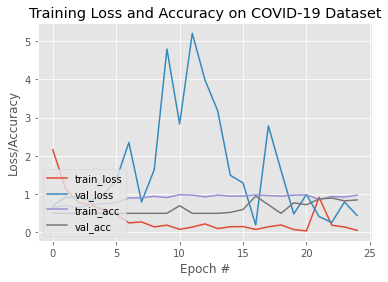

In [0]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# Data Visualization

In [0]:
metadata_dir = 'covid-chestxray-dataset/metadata.csv'
metadata = pd.read_csv(metadata_dir)
print(metadata.columns)
print(np.shape(metadata))
row , col = np.shape(metadata)
data = []
labels = []
path = 'covid/'
for i in range(row):
  imagePath = 'covid-chestxray-dataset/images/' + metadata.filename[i] 
  image = cv2.imread(imagePath)
  if metadata.finding[i] == 'COVID-19':
    cv2.imwrite(path,image)

In [0]:
print(metadata.finding[41:60], metadata.filename[41:60])

41    COVID-19
42    COVID-19
43    COVID-19
44    COVID-19
45    COVID-19
46    COVID-19
47    COVID-19
48    COVID-19
49    COVID-19
50    COVID-19
51    COVID-19
52    COVID-19
53    COVID-19
54    COVID-19
55    COVID-19
56    COVID-19
57    COVID-19
58        ARDS
59        ARDS
Name: finding, dtype: object 41               1-s2.0-S0929664620300449-gr2_lrg-b.jpg
42               1-s2.0-S0929664620300449-gr2_lrg-c.jpg
43               1-s2.0-S0929664620300449-gr2_lrg-d.jpg
44               1-s2.0-S0929664620300449-gr3_lrg-a.jpg
45               1-s2.0-S0929664620300449-gr3_lrg-b.jpg
46               1-s2.0-S0929664620300449-gr3_lrg-c.jpg
47               1-s2.0-S0929664620300449-gr3_lrg-d.jpg
48                         covid-19-pneumonia-15-PA.jpg
49                          covid-19-pneumonia-15-L.jpg
50                             covid-19-pneumonia-2.jpg
51                          covid-19-pneumonia-7-PA.jpg
52                           covid-19-pneumonia-7-L.jpg
53    radiopae

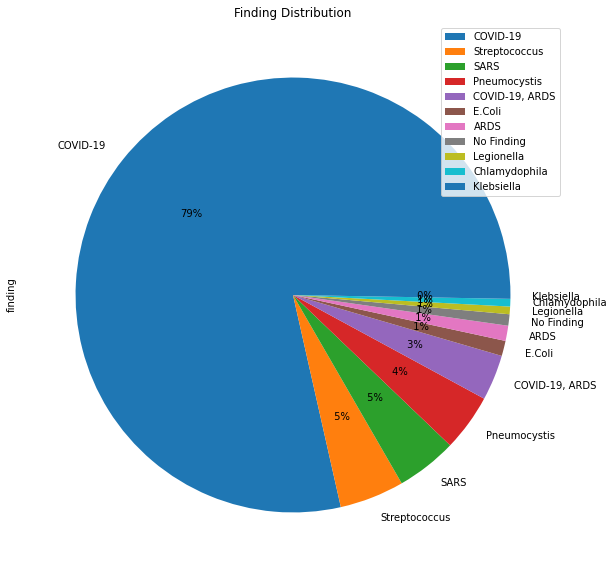

In [0]:
ax = metadata['finding'].value_counts(dropna=False).plot.pie(y='Finding', legend = True, autopct='%2.0f%%', figsize = (10,10), title = 'Finding Distribution')